<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_with_latent_subspaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoder Model (VAE) with latent subspaces based on:
https://arxiv.org/pdf/1812.06190.pdf

In [0]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

In [0]:
df1 = pd.read_csv("dge.txt",delimiter="\t")
df2 = pd.read_csv("geometry.txt",delimiter="\t")

In [0]:
X = df1.to_numpy()

In [0]:
U = df2.to_numpy()
U = U[0:X.shape[0],:]

In [0]:
U_temp = []
for i in range(X.shape[0]):
  ss = U[i][0]
  ff = np.fromstring(ss, dtype=float, sep=' ')
  U_temp.append(ff)

U = np.array(U_temp)
U = U/np.max(np.abs(U), axis=0)

In [0]:
#Reconstruction loss
def x_given_w_z(w, z, output_size):
  with tf.variable_scope('M/x_given_w_z'):
    act = tf.nn.leaky_relu
    
    h = tf.concat((w,z), axis=-1)
    loc = tf.layers.dense(h, output_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for w
def w_given_x_y(x, y, latent_size): #+
  with tf.variable_scope('M/w_given_x_y'):
    act = tf.nn.leaky_relu
    h = tf.concat((x,y), axis=-1)
    loc = tf.layers.dense(h,latent_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def w_given_y(y, y_size):
  with tf.variable_scope('M/w_given_y'):
    act = tf.nn.leaky_relu
    h = y
    loc = tf.layers.dense(h, y_size)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for z
def z_given_x(x, latent_size): #+
  with tf.variable_scope('M/z_given_x'):
    act = tf.nn.leaky_relu
    h = x
    loc = tf.layers.dense(h,latent_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def z_given(latent_size):
  with tf.variable_scope('M/z_given'):
    loc = tf.zeros(latent_size)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#For the Mutual information term
def y_given_z(z, y_size, reuse=None):
  with tf.variable_scope('N', reuse=reuse):
    act = tf.nn.leaky_relu
    h = z
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.float32, shape=[None, 3], name='u_in')


beta = np.array([1.0, 1.0, 1.0, 1.0, 1.0])

z_latent_size = 3
w_latent_size = 3

M_learning_rate = 1e-3
N_learning_rate = 1e-3

#KL_w
wIy = w_given_y(u_in, w_latent_size)
wIxy = w_given_x_y(x_in, u_in, w_latent_size)
wIxy_sample = wIxy.sample()
kl_w = tf.reduce_mean(wIxy.log_prob(wIxy_sample)- wIy.log_prob(wIxy_sample))

#KL_z
zI = z_given(z_latent_size)
zIx = z_given_x(x_in, z_latent_size)
zIx_sample = zIx.sample()
kl_z = tf.reduce_mean(zIx.log_prob(zIx_sample)- zI.log_prob(zIx_sample))

#Reconstruction
xIwz = x_given_w_z(wIxy_sample, zIx_sample, X.shape[1])
rec_loss = tf.losses.mean_squared_error(x_out, xIwz.mean())

M1 = beta[0]*rec_loss + beta[1]*kl_w + beta[2]*kl_z

yIz = y_given_z(zIx_sample, U.shape[1], reuse=False)
M2 = beta[3]*tf.reduce_mean(-yIz.entropy())

M_cost = M1 - M2

M_optimizer = tf.train.AdamOptimizer(M_learning_rate)

M_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='M')
M_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='M')

with tf.control_dependencies(M_update_ops):
  M_train = M_optimizer.minimize(M_cost, var_list=M_train_vars,
                                       name='train_M')

  
yIz_N = y_given_z(zIx_sample, U.shape[1], reuse=True)
N = beta[4]*tf.reduce_mean(-yIz_N.log_prob(u_in))

N_cost = N

N_optimizer = tf.train.AdamOptimizer(N_learning_rate)

N_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='N')
N_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='N')

with tf.control_dependencies(N_update_ops):
  N_train = N_optimizer.minimize(N_cost, var_list=N_train_vars,
                                       name='train_N')

# Saver to save session for reuse
saver = tf.train.Saver()

In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

In [99]:
n_epochs = 10000
batch_size = X.shape[0]//4
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  
  for i in range(n_epochs):
    gen = batch_generator(X, X, U, batch_size) #create batch generator
    M_loss = 0
    N_loss = 0
    
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      
      
      _, M_loss_= sess.run([M_train, M_cost], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch})
      M_loss += M_loss_
      
      _, N_loss_= sess.run([N_train, N_cost], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch})
      N_loss += N_loss_
      
      
    if (i+1)% 10 == 0 or i == 0:
      #latent_mean_, latent_sampled_, posterior_loc_= sess.run([latent_mean, latent_sampled, posterior_loc], feed_dict ={x_in:X, x_out:X, u_in:U})
      end = time.time()
      print('epoch: {0}, M_loss: {1:.4f}, N_loss: {2:.4f}, time: {3:.3f}'.format((i+1), M_loss/(1+np.int(X.shape[0]/batch_size)), N_loss/(1+np.int(X.shape[0]/batch_size)), end-start))
      start = time.time()

epoch: 1, M_loss: 10409.9318, N_loss: 5.8631, time: 0.636
epoch: 10, M_loss: 2230.2404, N_loss: 2.4937, time: 0.355
epoch: 20, M_loss: 1396.0006, N_loss: 2.3530, time: 0.389
epoch: 30, M_loss: 990.6417, N_loss: 2.2163, time: 0.419
epoch: 40, M_loss: 731.7418, N_loss: 2.1274, time: 0.399
epoch: 50, M_loss: 569.8258, N_loss: 2.0626, time: 0.384
epoch: 60, M_loss: 467.4363, N_loss: 2.0063, time: 0.401
epoch: 70, M_loss: 396.9219, N_loss: 1.9579, time: 0.383
epoch: 80, M_loss: 346.8344, N_loss: 1.9145, time: 0.384
epoch: 90, M_loss: 306.4317, N_loss: 1.8734, time: 0.393
epoch: 100, M_loss: 274.8459, N_loss: 1.8352, time: 0.398
epoch: 110, M_loss: 248.9123, N_loss: 1.7981, time: 0.378
epoch: 120, M_loss: 226.0654, N_loss: 1.7630, time: 0.375
epoch: 130, M_loss: 206.3948, N_loss: 1.7298, time: 0.390
epoch: 140, M_loss: 190.1215, N_loss: 1.6980, time: 0.398
epoch: 150, M_loss: 175.6455, N_loss: 1.6675, time: 0.387
epoch: 160, M_loss: 162.2270, N_loss: 1.6392, time: 0.371
epoch: 170, M_loss: 1

KeyboardInterrupt: ignored

Text(0, 0.5, 'z2')

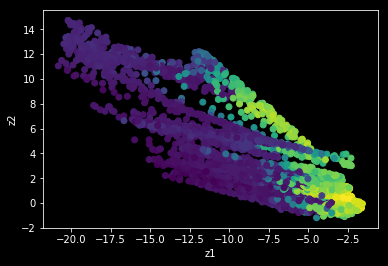

In [0]:
plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=df1['sna'].to_numpy(), cmap='viridis');
plt.xlabel('z1')
plt.ylabel('z2')

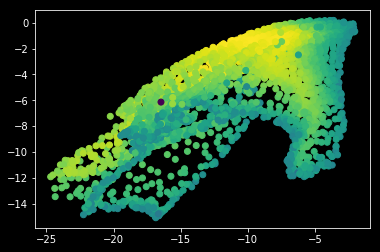

In [0]:
plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=U[:,1], cmap='viridis');

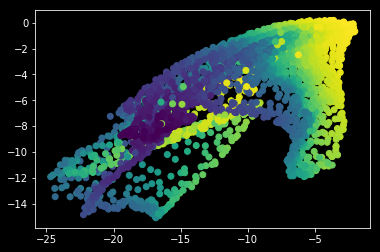

In [0]:
plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=U[:,2], cmap='viridis');

In [0]:
df1['sna'].to_numpy()

array([0.111794, 0.221231, 0.159118, ..., 0.746477, 0.893983, 0.009584])

In [0]:
# def configure_plotly_browser_state():
#   import IPython
#   display(IPython.core.display.HTML('''
#         <script src="/static/components/requirejs/require.js"></script>
#         <script>
#           requirejs.config({
#             paths: {
#               base: '/static/base',
#               plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
#             },
#           });
#         </script>
#         '''))

# import plotly.plotly as py
# from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

# configure_plotly_browser_state()

# init_notebook_mode(connected=False)


# import plotly.graph_objs as go


# trace1 = go.Scatter3d(
#     x=latent_mean_[:,0],
#     y=latent_mean_[:,1],
#     z=latent_mean_[:,2],
#     name = 'train data: line',
#     mode='markers',
#     marker=dict(
#         size=3.0,
#         color=df1['sna'].to_numpy(),                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         opacity=0.8
#     )
# )


# data = [trace1]
# layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
# )



# fig = go.Figure(data=data, layout=layout)
# iplot(fig, filename='3d-scatter-colorscale')